In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import librosa.display
import re
import ast
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 

# Preprocessing audio data
Read in audio files information from data.csv and compute list of randomized files to be selected for our training and testing data

In [2]:
%run utilities.py
file_names = generate_file_names("data.csv")

In [3]:
%run utilities.py
"""
Go to "audio" folder and generate melspectrogram and mfccs for each .wav file in file_names
"""
count = 0
df = pd.DataFrame(columns = ["File", "melspec", "mfccs"])
for file in file_names:
    s, mfccs = compute_mel_spect("audio/" + file + ".wav")
    df = df.append(pd.DataFrame({"File": [file, "melspec": [s], "mfccs": [mfccs]}))
    count +=1
    if (count%240 ==0):
        print(count/240)

In [4]:
df = df.reset_index(drop=True)
df["File"] = file_names
"""Make an instrument column to indicate which instrument family the data belongs to"""
instruments = []
for x in df["File"]:
    word = ""
    for char in x:
        if (char!= '_'):
            word += char
        else:
            break
    instruments.append(word)
df["instrument"] = instruments
"""Save large dataframe to Pickle"""
df.to_pickle("audio_data.pkl")

Also use magic functions to save our dataframe "magically"

In [105]:
df_main = df.copy()
%store df_main

Stored 'df_main' (DataFrame)


# Start here if preprocessing has been completed

In [2]:
%store -r
df = df_main
df["log_melspec"] = [np.log(df.melspec[x]) for x in range(0,len(df))]
df["mfccs_reverse"] = [np.flip(df.mfccs[x]) for x in range(0, len(df))]
df["mfcc_scaled"] = [np.mean(df.mfccs[x].T,axis=0)for x in range(0, len(df))]

In [3]:
df.head(5)

,File,melspec,mfccs,instrument,log_melspec,mfccs_reverse,mfcc_scaled
0,mallet_acoustic_054-072-025,"[[0.03501896, 0.011045308, 3.1287727e-05, 3.14...","[[-200.43701, -248.2736, -433.00623, -439.3638...",mallet,"[[-3.3518658, -4.5057497, -10.372285, -14.9727...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-475.59848, 11.259514, 4.5130334, 1.6110848, ..."
1,mallet_acoustic_077-060-100,"[[0.015199626, 0.004671174, 0.00032956226, 0.0...","[[-51.170395, -88.10801, -181.91718, -229.1377...",mallet,"[[-4.1864843, -5.366345, -8.017745, -9.103788,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-536.3193, 10.817133, -5.3501606, 9.1420965, ..."
2,mallet_acoustic_012-029-025,"[[1901.978, 1960.1753, 1162.3447, 864.8757, 63...","[[-111.2322, -136.95949, -231.26842, -374.4199...",mallet,"[[7.5506496, 7.580789, 7.0581946, 6.7625856, 6...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-501.5868, 6.6479683, 3.4846163, 5.4132414, 4..."
3,mallet_acoustic_016-107-025,"[[0.09860557, 0.038477868, 0.0028630681, 0.000...","[[-314.497, -330.2767, -415.51758, -500.49908,...",mallet,"[[-2.3166275, -3.257672, -5.8558617, -8.017719...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-655.67303, -6.0052004, -3.633986, 10.394158,..."
4,mallet_acoustic_024-036-050,"[[51.42106, 35.015034, 3.1608453, 0.36858353, ...","[[-223.99571, -265.6873, -370.84644, -432.0723...",mallet,"[[3.9400477, 3.5557775, 1.1508394, -0.99808794...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-494.6668, 10.519091, 8.364085, 7.442548, 6.3..."


# Prepare dataset by one-hot-encoding categories and train test split

For now, let's only use melspectrogram data. The same should be repeated for all other train/test procedures

In [4]:
%run utilities.py

# Build and train model

In [5]:
num_rows = 40
num_columns = 173
num_channels = 1
column_to_be_trained = df.mfccs

x_train, x_test, y_train, y_test,le = get_trains_tests(column_to_be_trained, df)

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_test.shape)

num_labels = 8
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

(24000, 8)
(4800, 40, 173, 1)


In [6]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn_mel_spec222.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 19200 samples, validate on 4800 samples
Epoch 1/72
18944/19200 [============================>.] - ETA: 0s - loss: 4.1204 - accuracy: 0.2634
Epoch 00001: val_loss improved from inf to 1.77297, saving model to saved_models/weights.best.basic_cnn_mel_spec222.hdf5
19200/19200 [==============================] - 8s 400us/sample - loss: 4.0895 - accuracy: 0.2647 - val_loss: 1.7730 - val_accuracy: 0.3321
Epoch 2/72
18944/19200 [============================>.] - ETA: 0s - loss: 1.6660 - accuracy: 0.3936
Epoch 00002: val_loss improved from 1.77297 to 1.62803, saving model to saved_models/weights.best.basic_cnn_mel_spec222.hdf5
19200/19200 [==============================] - 6s 295us/sample - loss: 1.6632 - accuracy: 0.3944 - val_loss: 1.6280 - val_accuracy: 0.3681
Epoch 3/72
18944/19200 [============================>.] - ETA: 0s - loss: 1.4205 - accuracy: 0.4694
Epoch 00003: val_loss improved from 1.62803 to 1.50045, saving model to saved_models/weights.best.basic_cnn_mel_spec222.hdf5
19

Epoch 24/72
18944/19200 [============================>.] - ETA: 0s - loss: 0.5561 - accuracy: 0.8029
Epoch 00024: val_loss improved from 0.65202 to 0.63570, saving model to saved_models/weights.best.basic_cnn_mel_spec222.hdf5
19200/19200 [==============================] - 6s 295us/sample - loss: 0.5558 - accuracy: 0.8029 - val_loss: 0.6357 - val_accuracy: 0.7962
Epoch 25/72
18944/19200 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.8110
Epoch 00025: val_loss improved from 0.63570 to 0.60242, saving model to saved_models/weights.best.basic_cnn_mel_spec222.hdf5
19200/19200 [==============================] - 6s 302us/sample - loss: 0.5371 - accuracy: 0.8110 - val_loss: 0.6024 - val_accuracy: 0.8052
Epoch 26/72
18944/19200 [============================>.] - ETA: 0s - loss: 0.5263 - accuracy: 0.8167
Epoch 00026: val_loss improved from 0.60242 to 0.58469, saving model to saved_models/weights.best.basic_cnn_mel_spec222.hdf5
19200/19200 [==============================]

Epoch 49/72
18944/19200 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8777
Epoch 00049: val_loss did not improve from 0.38355
19200/19200 [==============================] - 6s 290us/sample - loss: 0.3457 - accuracy: 0.8778 - val_loss: 0.3873 - val_accuracy: 0.8710
Epoch 50/72
18944/19200 [============================>.] - ETA: 0s - loss: 0.3404 - accuracy: 0.8780
Epoch 00050: val_loss did not improve from 0.38355
19200/19200 [==============================] - 6s 289us/sample - loss: 0.3405 - accuracy: 0.8779 - val_loss: 0.3984 - val_accuracy: 0.8700
Epoch 51/72
18944/19200 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8822
Epoch 00051: val_loss did not improve from 0.38355
19200/19200 [==============================] - 6s 297us/sample - loss: 0.3285 - accuracy: 0.8827 - val_loss: 0.3977 - val_accuracy: 0.8696
Epoch 52/72
18944/19200 [============================>.] - ETA: 0s - loss: 0.3233 - accuracy: 0.8870
Epoch 00052: val_loss did 

In [8]:
model.load_weights("saved_models/weights.best.basic_cnn_mfccs.hdf5")

In [9]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9658854
Testing Accuracy:  0.9402083


In [10]:
predictions = model.predict_classes(x_test)
actuals = list(np.argmax(x) for x in y_test)

Normalized confusion matrix


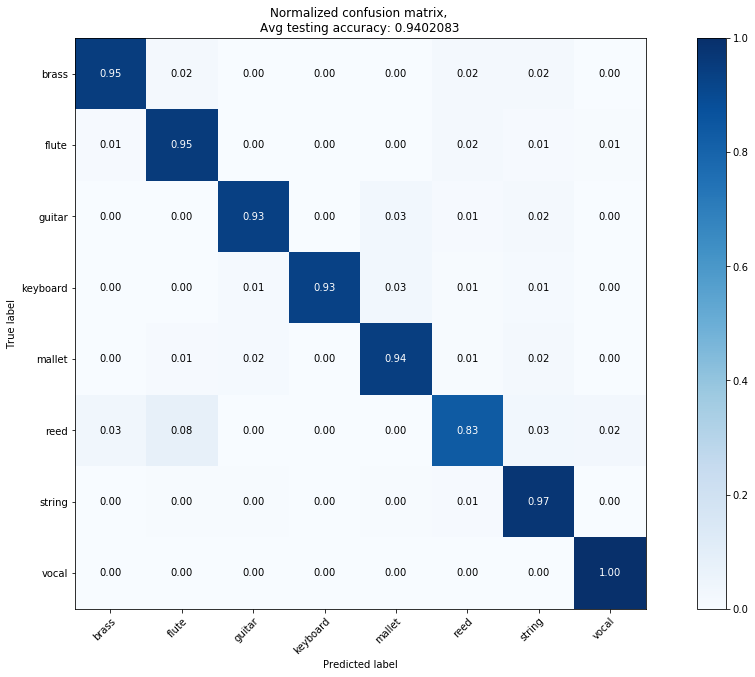

In [11]:
ax = plot_confusion_matrix(actuals, predictions, score[1], le.classes_, normalize =True)
plt.savefig("reversed.png", bbox_layout = "tight")
plt.show()

## Reversing MFCC data. Will this break our best model?

In [219]:
file = "weights.best.basic_cnn_mfccs.hdf5"
model.load_weights("saved_models/" + file)
# Evaluating the model on the testing set

In [222]:
x_train, x_test, y_train, y_test = get_trains_tests(df.mfccs_reverse)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

predictions = model.predict_classes(x_test)
actuals = list(np.argmax(x) for x in y_test)

Testing Accuracy:  0.27895832


In [223]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.27895832


Looks like it did very poorly, with a 27 percent accuracy.

Normalized confusion matrix


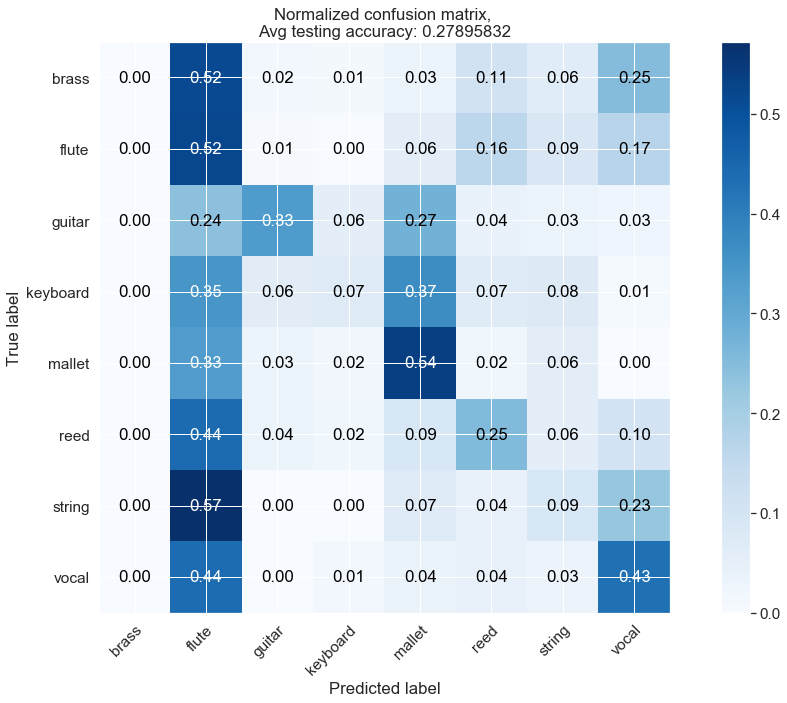

In [224]:
ax = plot_confusion_matrix(actuals, predictions, score[1], le.classes_, normalize =True)
plt.show()

# Break model with other instrument sources like Electronic or synthetic

### Electronic

In [237]:
#pre processing
df = pd.read_csv("data.csv")
#if you want to limit the pitch of the dataframe
df2 = df[df["instrument_source_str"] == "electronic"]
file_names =[]
for col in df2["instrument_family_str"].value_counts().index:
    if (col!= "bass" and col != "organ"):
        df3 = df2[df2["instrument_family_str"] == col].reset_index()
        arr = np.arange(len(df3))
        np.random.shuffle(arr)
        for j in arr[:600]:
            file_names.append(df3["Unnamed: 0.1"][j])
count = 0
e_df = pd.DataFrame(columns = ["File", "melspec", "mfccs"])
for file in file_names:
    s, mfccs = compute_mel_spect("audio/" + file + ".wav")
    e_df = e_df.append(pd.DataFrame({"File": [file], "melspec": [s], "mfccs": [mfccs]}))
    count +=1
    if (count%48 ==0):
        print(count/48,)

# add instruments column for labels        
instruments = []
for x in e_df["File"]:
    word = ""
    for char in x:
        if (char!= '_'):
            word += char
        else:
            break
    instruments.append(word)
e_df["instrument"] = instruments

In [327]:
X = np.array(e_df.mfccs.tolist())
y = np.array(e_df.instrument.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
x_test = X
y_test = yy

Testing Accuracy:  0.35600907
Normalized confusion matrix


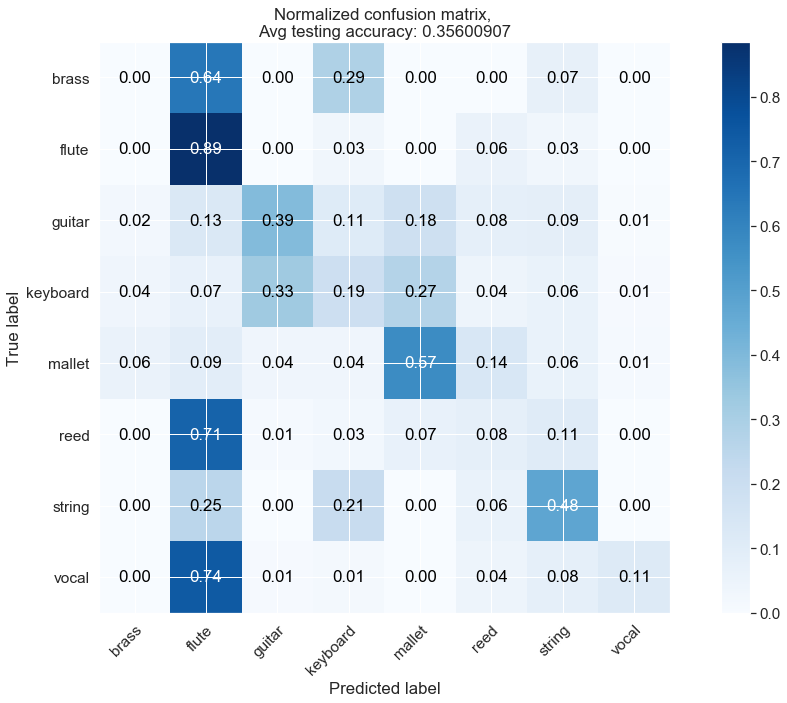

In [268]:
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

predictions = model.predict_classes(x_test)
actuals = list(np.argmax(x) for x in y_test)

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

ax = plot_confusion_matrix(actuals, predictions, score[1], le.classes_, normalize =True)
plt.savefig("Electronic_insts_on_network_confusion.png")
plt.show()

### synthetic

In [12]:
#pre processing
df = pd.read_csv("data.csv")
#if you want to limit the pitch of the dataframe
df2 = df[df["instrument_source_str"] == "synthetic"]
file_names =[]
for col in df2["instrument_family_str"].value_counts().index:
    if (col!= "bass" and col != "organ" and col != "synth_lead"):
        df3 = df2[df2["instrument_family_str"] == col].reset_index()
        arr = np.arange(len(df3))
        np.random.shuffle(arr)
        for j in arr[:600]:
            file_names.append(df3["Unnamed: 0.1"][j])
count = 0
s_df = pd.DataFrame(columns = ["File", "melspec", "mfccs"])
for file in file_names:
    s, mfccs = compute_mel_spect("audio/" + file + ".wav")
    s_df = s_df.append(pd.DataFrame({"File": [file], "melspec": [s], "mfccs": [mfccs]}))
    count +=1
    if (count%48 ==0):
        print(count/48,)

# add instruments column for labels        
instruments = []
for x in s_df["File"]:
    word = ""
    for char in x:
        if (char!= '_'):
            word += char
        else:
            break
    instruments.append(word)
s_df["instrument"] = instruments

In [345]:
X = np.array(s_df.mfccs.tolist())
y = np.array(s_df.instrument.tolist())

In [346]:
class_dict ={}
count = 0
for x in le.classes_:
    class_dict[x] = count
    count +=1

In [13]:
codings = np.zeros((3528,8))
for line in range(len(codings)):
    index =class_dict[y[line]]
    codings[line][index] = 1
codings

In [362]:
x_test = X
y_test = codings

Testing Accuracy:  0.22477324
Normalized confusion matrix


c:\users\elong\anaconda3\envs\instrument_ai\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


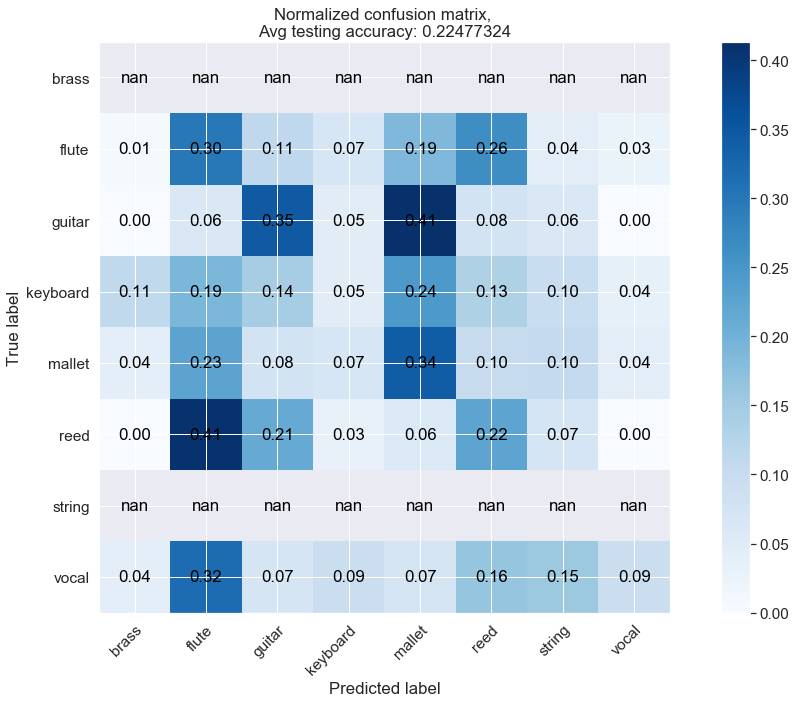

In [366]:
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)


predictions = model.predict_classes(x_test)
actuals = list(np.argmax(x) for x in y_test)

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

ax = plot_confusion_matrix(actuals, predictions, score[1], le.classes_, normalize =True)
plt.savefig("Synthetic_insts_on_network_confusion.png")
plt.show()

## Model breakage summary 

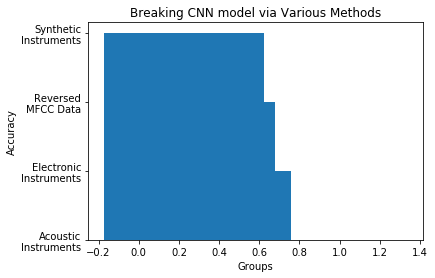

In [79]:
types = ["Acoustic\nInstruments", "Electronic\nInstruments", "Reversed\nMFCC Data","Synthetic\nInstruments"]
values = [0.94, 0.356, 0.279, 0.225]
ax = plt.bar(x = values,height = types)
plt.title("Breaking CNN model via Various Methods")
plt.xlabel("Groups")
plt.ylabel("Accuracy")
plt.savefig("break_over_time.png", bbox_inches = "tight")

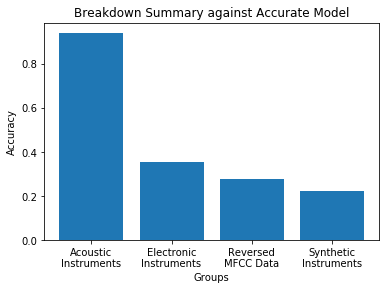

In [82]:
types = ["Acoustic\nInstruments", "Electronic\nInstruments", "Reversed\nMFCC Data","Synthetic\nInstruments"]
values = [0.94, 0.356, 0.279, 0.225]
insts =["Acoustic\nInstruments", "Electronic\nInstruments", "Synthetic\nInstruments"]
ivs =[0.94, 0.356, 0.225]
ax = plt.bar(x = types, height = values)
plt.title("Breakdown Summary against Accurate Model")
plt.xlabel("Groups")
plt.ylabel("Accuracy")
plt.savefig("Instrument_types.png", bbox_inches = "tight")